通过生成沪深300指数股在收益率均值回归基础上的胜率，通过分析胜率与因子的相关性，确定选股规则：
1. 提取指数股，开始循环计算
2. 计算统计期内的关键参数
3. 计算所有股票在验证期内的胜率
4. 提取验证期时间开头的因子
5. 对比因子与胜率排名的相关性

In [9]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.tsa.stattools as ts


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA


from jqfactor import *
from jqdata import *

# 导入函数

In [10]:
# S1为自变量，S2为因变量
def kalman_beta(S1,S2):
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(S1.values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(S2[:, np.newaxis])
    
    # 第一个参数为beta，第二个参数为alpha
    return state_means[-1]



# 进行画图，判断AR、MA的延迟阶数

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res)
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]


# 生成持仓序列
# 输入：
# buy_list:[0,....,1,0,...]
# sell_list:[0,...-1,0,-1....]
# 相互融合后生成持仓序列：[0,0,....1,0,1,....]

def position_generate(buy_list,sell_list):
    # 生成混合序列
    combine_list = np.array(buy_list) + np.array(sell_list)


    # 生成状态序列
    state_list = []
    # 1、初始化第一个状态，如果是0则设置为-1，如果是-1则保持-1，如果是1则保持1
    if combine_list[0] == 0:
        state_list.append(-1)
    else:
        state_list.append(combine_list[0])

    # 2、开始设置后续的状态，如果是0则设置为前一个状态，如果当前状态与前一个状态不同，则设置为当前状态
    for state in combine_list[1:]:
        if state == 0:
            state_list.append(state_list[-1])
        else:
            state_list.append(state)

    # 进行异或操作
    xor_list = []
    for i in range(len(state_list)):
        if state_list[i] == np.array(pd.Series(state_list).shift(1).fillna(-1))[i]:
            xor_list.append(0)
        else:
            xor_list.append(1)

    # 生成新的买入、卖出数组
    buy_point_new = np.array(buy_list) * xor_list
    sell_point_new = np.array(sell_list) * xor_list

    # 生成新的混合数组
    combine_list_new = buy_point_new + sell_point_new
    
    # 调试
    # 因为是在收盘时交易，所以要调整1位
    # 如果在开盘交易，则不需要调整
    ret_list = list(np.cumsum(combine_list_new))
    ret_list.insert(0,0)
    ret_list.pop(len(ret_list)-1)
    
    
    
    return np.array(ret_list)


def position_generate_buy(buy_list):

    # 生成状态序列
    ret_list = buy_list[:]

    
    # 调试
    # 因为是在收盘时交易，所以要调整1位
    # 如果在开盘交易，则不需要调整
    ret_list.insert(0,0)
    ret_list.pop(len(ret_list)-1)
    
    
    
    return np.array(ret_list)

#获取数据主函数
#输入股票池、指标名称、开始日期、结束日期
#返回行标签为日期，列表签为股票名称的dataframe表格
def get_factor_data(stockPool, factor,date_start, date_end):
    
    #获取股票池函数
    def get_stock(stockPool, begin_date):
        if stockPool == 'HS300':#用于获取沪深300股票池
            stockList = get_index_stocks('000300.XSHG', begin_date)
        elif stockPool == 'ZZ500':#用于获取中证500股票池
            stockList = get_index_stocks('399905.XSHE', begin_date)
        elif stockPool == 'ZZ800':#用于获取中证800股票池
            stockList = get_index_stocks('399906.XSHE', begin_date)   
        elif stockPool == 'A':#用于获取全部A股股票池
            stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks('399107.XSHE', begin_date)
        else:#自定义输入股票池
            stockList = stockPool
        return stockList    
    
    #从财务库获取数据
    def get_factor_data1(factor,stock, date):
        if factor in val:
            q = query(valuation).filter(valuation.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in bal:
            q = query(balance).filter(balance.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in cf:
            q = query(cash_flow).filter(cash_flow.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in inc:
            q = query(income).filter(income.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in ind:
            q = query(indicator).filter(indicator.code.in_(stock))
            df = get_fundamentals(q, date)

        df.index = df['code']
        data = pd.DataFrame(index = df.index)
        data[date] = df[factor]

        return data.T
    #获取日期列表
    date_list = get_trade_days(start_date = date_start, end_date = date_end)
    #空df预备存储数据
    data = pd.DataFrame(columns = get_stock(stockPool,begin_date=date_list[-1]))
    
    #获取五张财务基础所有指标名称
    val = get_fundamentals(query(valuation).limit(1)).columns.tolist()
    bal = get_fundamentals(query(balance).limit(1)).columns.tolist()
    cf = get_fundamentals(query(cash_flow).limit(1)).columns.tolist()
    inc = get_fundamentals(query(income).limit(1)).columns.tolist()
    ind = get_fundamentals(query(indicator).limit(1)).columns.tolist()
    all_columns = val+bal+cf+inc+ind
    
    #循环时间列表获取指标数据
    for date in date_list:

        #获取股票池
        all_stocks = get_stock(stockPool, date)
        #获取因子数据
        if factor in all_columns: #可以从财务库直接取到因子值的因子
            data_temp = get_factor_data1(factor,all_stocks, date)
        else: #可以从因子库直接取到因子值的因子
            try:
                data_temp = get_factor_values(all_stocks, [factor], end_date = date, count = 1)[factor]
            except:
                print('系统暂不能获取该因子，请获取其他因子')
                break
        data = pd.concat([data, data_temp], axis = 0) 
    return data

# 设置核心参数

In [17]:
# 交易周期
period = '5d'

# 参数周期
ncount = 100
end_date_para = '2017-11-1'

# 验证周期
start_date_validation = '2017-11-1'
end_date_validation = '2018-5-1'

sec_pool = get_index_stocks('000300.XSHG', end_date_para)


# 开始进行循环提取胜率

In [18]:
# 调试用
# sec_pool = ['600104.XSHG']

# 存储的字典
ret_dict = {}

# 开始对sec_pool中的股票进行循环
for sec in sec_pool:
    
    ret_dict[sec] = []
    
    
    sec1 = '000300.XSHG'
    sec2 = sec
    
    # 观测参数
    S1 = get_price(sec1, count =  ncount, end_date= end_date_para, frequency=period, fields='close',fq = "none")['close']
    P = S1/S1.shift(1)
    P = P.fillna(1)

    # 操作参数
    S2 = get_price(sec2, count =  ncount, end_date= end_date_para, frequency=period, fields='close',fq = "none")['close']
    Q = S2/S2.shift(1)
    Q = Q.fillna(1)
    
    # 计算alpha、beta
    # 按照定义：S1为自变量，S2为因变量
    beta_kf = kalman_beta(P,Q)
    beta = kalman_beta(P,Q)[0]
    alpha = kalman_beta(P,Q)[1]
    
    # 计算残差
    res = Q - np.dot(sm.add_constant(P, prepend=False), beta_kf)
    
    # 加入均方根、残差检验
    ret_dict[sec].append(Cadf_test(res))
    ret_dict[sec].append(test_stochastic(res))

    
#     # 检验残差是否存在均方根
#     if Cadf_test(res) < 0.05:
#         continue
    
#     # 检验残差是否为随机序列
#     if test_stochastic(res) > 0.05:
#         continue
    
    # 求出方差
    std_deviation = np.std(res)
    
    # 求出均值
    mean = np.mean(res)
    
    
    # 开始验证
    # 指数,P
    S1_validation = get_price(sec1, start_date =  start_date_validation, end_date= end_date_validation, frequency=period, fields='close',fq = "none")['close']
    P_validation = S1_validation/S1_validation.shift(1)
    P_validation = P_validation.fillna(1)


    # 个股,Q
    S2_validation = get_price(sec2, start_date =  start_date_validation, end_date= end_date_validation, frequency=period, fields='close',fq = "none")['close']
    Q_validation = S2_validation/S2_validation.shift(1)
    Q_validation = Q_validation.fillna(1)
    
    
    # 求出差距
    Q_infer = beta*P_validation + alpha

    gap = Q_validation - Q_infer 
    
    # 求出买入时机
    buy_point_pd  = gap < mean - 2*std_deviation
    buy_point_list = [int(d) for d in buy_point_pd ]
    
    # 临时存放数据的pandas
    data_total_pd = pd.DataFrame()
    
    # 交易位置信息
    pos_pd =pd.Series(position_generate_buy(buy_point_list))
    pos_pd.index =S2_validation.index
    
    
    # 数据整合
    data_total_pd = pd.concat([data_total_pd,
                            S1_validation,
                            S1_validation.shift(1).iloc[0:S1_validation.shape[0]],
                            S1_validation/S1_validation.shift(1).iloc[0:S1_validation.shape[0]],

                            S2_validation,
                            S2_validation.shift(1).iloc[0:S2_validation.shape[0]],
                            S2_validation/S2_validation.shift(1).iloc[0:S1_validation.shape[0]],
                            gap,
                            pos_pd
                          
                          ],
                          axis=1)

    data_total_pd.columns = ['S1','S1_pre','S1_yield','S2','S2_pre','S2_yield','gap','pos']
    
    
    try_num = sum(data_total_pd['pos'])
    win_num = sum((data_total_pd['S2_yield']>data_total_pd['S1_yield'])*data_total_pd['pos'])
    win_rate = sum((data_total_pd['S2_yield']>data_total_pd['S1_yield'])*data_total_pd['pos'])/sum(data_total_pd['pos'])
    
    
    # 加入胜率结果
    ret_dict[sec].append(try_num)
    ret_dict[sec].append(win_num)
    ret_dict[sec].append(win_rate)
    
    
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in long_scalars


In [19]:
pd.DataFrame(ret_dict).T.to_csv('stock_winrate_1st.csv')

# 提取因子

In [119]:
# 定义需要提取的因子库

factor_pool = [
            'pe_ratio',                                    # pe
            'pb_ratio',                                    # pb
            'roe',                                         # 净资产收益率ROE(%)
            'inc_total_revenue_year_on_year',              # 营业总收入同比增长率(%)
            'inc_operation_profit_year_on_year',           # 营业利润同比增长率(%)
            'inc_net_profit_to_shareholders_year_on_year', # 归属母公司股东的净利润同比增长率(%)
            'inc_total_revenue_year_on_year',              # 营业总收入同比增长率(%)
            'net_profit_to_total_operate_revenue_ttm',     # 净利润与营业总收入之比
            'cfo_to_ev',                                   # 经营活动产生的现金流量净额与企业价值之比TTM
            'net_profit_ratio',                            # 销售净利率
            'fixed_asset_ratio',                           # 固定资产比率
            'net_operating_cash_flow_coverage',            # 净利润现金含量
            'operating_profit_growth_rate',                # 营业利润增长率
            'long_debt_to_working_capital_ratio',          # 长期负债与营运资金比率
            'total_asset_turnover_rate',                   # 总资产周转率
            'roa_ttm',                                     # 资产回报率TTM
            'equity_to_asset_ratio',                       # 股东权益比率
            'roe_ttm',                                     # 权益回报率TTM
            'DEGM',                                        # 毛利率增长
            'quick_ratio',                                 # 速动比率
            'net_operate_cash_flow_to_asset',              # 总资产现金回收率
            'ROAEBITTTM',                                  # 总资产报酬率
            'long_term_debt_to_asset_ratio',               # 长期负债与资产总计之比
            'operating_profit_to_total_profit',            # 经营活动净收益/利润总额
            'fixed_assets_turnover_rate',                  # 固定资产周转率
            'gross_income_ratio',                          # 销售毛利率
            'operating_revenue_growth_rate',               # 营业收入增长率
            'total_asset_growth_rate',                     # 总资产增长率
            'np_parent_company_owners_growth_rate'        # 归属母公司股东的净利润增长率
            ]

In [120]:
# # 调试用
# sec_pool = ['000651.XSHE','000415.XSHE']
# factor_pool = ['pe_ratio','pb_ratio']

factor_ret_pd = pd.DataFrame()

for factor_single in factor_pool[0:]:
    
    print(factor_single)
    
    pd_temp = pd.DataFrame()
    
    # 仅提取第一天的数据
    pd_temp[factor_single] = get_factor_data(sec_pool, factor_single,start_date_validation, end_date_validation).iloc[0,:].T

    factor_ret_pd = pd.concat([factor_ret_pd,pd_temp],
                              axis = 1
             )

pe_ratio
pb_ratio
roe
inc_total_revenue_year_on_year
inc_operation_profit_year_on_year
inc_net_profit_to_shareholders_year_on_year
inc_total_revenue_year_on_year
net_profit_to_total_operate_revenue_ttm
cfo_to_ev
net_profit_ratio
fixed_asset_ratio
net_operating_cash_flow_coverage
operating_profit_growth_rate
long_debt_to_working_capital_ratio
total_asset_turnover_rate
roa_ttm
equity_to_asset_ratio
roe_ttm
DEGM
quick_ratio
net_operate_cash_flow_to_asset
ROAEBITTTM
long_term_debt_to_asset_ratio
operating_profit_to_total_profit
fixed_assets_turnover_rate
gross_income_ratio
operating_revenue_growth_rate
total_asset_growth_rate
np_parent_company_owners_growth_rate


In [121]:
factor_ret_pd

,pe_ratio,pb_ratio,roe,inc_total_revenue_year_on_year,inc_operation_profit_year_on_year,inc_net_profit_to_shareholders_year_on_year,inc_total_revenue_year_on_year,net_profit_to_total_operate_revenue_ttm,cfo_to_ev,net_profit_ratio,fixed_asset_ratio,net_operating_cash_flow_coverage,operating_profit_growth_rate,long_debt_to_working_capital_ratio,total_asset_turnover_rate,roa_ttm,equity_to_asset_ratio,roe_ttm,DEGM,quick_ratio,net_operate_cash_flow_to_asset,ROAEBITTTM,long_term_debt_to_asset_ratio,operating_profit_to_total_profit,fixed_assets_turnover_rate,gross_income_ratio,operating_revenue_growth_rate,total_asset_growth_rate,np_parent_company_owners_growth_rate
code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.XSHE,7.5925,0.8638,3.06,14.21,7.93,7.35,14.21,0.217480,0.009252,0.217480,0.002796,-2.648927,0.053020,NaN,0.033596,0.007307,0.070175,0.104119,NaN,NaN,0.008322,0.008987,NaN,1.001413,13.322332,NaN,0.066651,0.068391,0.063344
000002.XSHE,8.7114,1.9255,3.54,48.12,71.27,28.31,48.12,0.146411,0.029515,0.146411,0.008606,-4.418205,0.406501,1.023308,0.210735,0.030854,0.150739,0.204684,0.113147,0.483189,0.027849,0.011980,0.120228,1.002561,30.012273,0.354020,0.254844,0.406370,0.297433
000060.XSHE,15.5434,1.4752,1.61,13.58,-44.05,-47.56,13.58,0.047285,0.115118,0.047387,0.329333,3.652596,0.108171,2.133406,1.074699,0.050927,0.542904,0.093805,-0.048234,0.853547,0.119350,0.018787,0.125342,1.002806,3.391260,0.126278,0.126315,0.051986,-0.047530
000063.XSHE,-10.9326,3.1740,2.52,-14.34,-45.19,-64.98,-14.34,-0.068352,0.001181,-0.068352,0.083548,-9.170612,-0.857565,1.219284,0.732616,-0.050076,0.276746,-0.180944,0.052307,0.749428,0.001349,-0.011619,0.074344,1.246268,8.844316,0.313908,-0.143504,-0.149380,4.028923
000069.XSHE,5.3492,0.8927,5.71,76.22,3.54,2.65,76.22,0.207714,-0.092734,0.207714,0.060465,-3.720070,0.200971,0.848823,0.173606,0.036060,0.256425,0.140627,0.110428,0.769249,-0.071240,0.013851,0.324561,1.001370,2.876111,0.560058,0.327468,0.387071,0.034555
000100.XSHE,10.3042,1.1196,3.04,-1.04,-19.27,3.61,-1.04,0.030340,0.067091,0.030368,0.354488,3.520112,0.061493,53.876610,0.611517,0.018571,0.314795,0.058992,-0.085062,0.810253,0.053046,0.006553,0.266002,0.980038,2.085981,0.184100,0.005446,0.134179,0.648603
000157.XSHE,19.5307,0.7045,1.18,24.55,474.93,190.95,24.55,0.049432,0.071507,0.049432,0.070441,3.326022,3.872459,0.573680,0.304329,0.015043,0.438490,0.034308,0.145876,1.937536,0.055308,0.004814,0.233923,0.986099,4.274121,0.252906,0.112187,0.009150,0.175131
000166.XSHE,23.3303,1.4606,1.82,-7.88,-20.22,-18.77,-7.88,0.339022,-0.123088,0.339022,0.003977,-3.388075,-0.160667,NaN,0.037528,0.012723,0.203207,0.062610,NaN,NaN,-0.108693,0.004131,NaN,1.001374,9.437888,NaN,-0.077819,0.208567,-0.158685
000333.XSHE,12.7128,3.0968,6.12,1.38,24.38,18.55,1.38,0.082582,0.063265,0.083231,0.094366,2.412844,0.282185,0.792184,1.011178,0.084161,0.358398,0.234826,0.040717,1.225179,0.093374,0.025939,0.161103,0.991795,10.940104,0.265699,0.130243,0.059739,0.196225


In [122]:
factor_ret_pd.to_csv('factor_ret_pd.csv')

# 附：求出最佳的时间间隔

In [98]:
# 参数周期
ncount = 100
end_date_para = '2018-10-31'

# 验证周期
start_date_validation = '2018-11-1'
end_date_validation = '2019-4-20'

sec_pool = get_index_stocks('000300.XSHG', end_date_para)

In [112]:
# 交易周期
period_pool = ['%dd'%(int(days)) for days in range(1,6)]

# 存储胜率的dict
win_rate_period = {}

In [113]:
for period in period_pool:

    # 存储的字典
    ret_dict = {}

    # 开始对sec_pool中的股票进行循环
    for sec in sec_pool:

        ret_dict[sec] = []


        sec1 = '000300.XSHG'
        sec2 = sec

        # 观测参数
        S1 = get_price(sec1, count =  ncount, end_date= end_date_para, frequency=period, fields='close',fq = "none")['close']
        P = S1/S1.shift(1)
        P = P.fillna(1)

        # 操作参数
        S2 = get_price(sec2, count =  ncount, end_date= end_date_para, frequency=period, fields='close',fq = "none")['close']
        Q = S2/S2.shift(1)
        Q = Q.fillna(1)

        # 计算alpha、beta
        # 按照定义：S1为自变量，S2为因变量
        beta_kf = kalman_beta(P,Q)
        beta = kalman_beta(P,Q)[0]
        alpha = kalman_beta(P,Q)[1]

        # 计算残差
        res = Q - np.dot(sm.add_constant(P, prepend=False), beta_kf)

        # 加入均方根、残差检验
        ret_dict[sec].append(Cadf_test(res))
        ret_dict[sec].append(test_stochastic(res))


    #     # 检验残差是否存在均方根
    #     if Cadf_test(res) < 0.05:
    #         continue

    #     # 检验残差是否为随机序列
    #     if test_stochastic(res) > 0.05:
    #         continue

        # 求出方差
        std_deviation = np.std(res)

        # 求出均值
        mean = np.mean(res)


        # 开始验证
        # 指数,P
        S1_validation = get_price(sec1, start_date =  start_date_validation, end_date= end_date_validation, frequency=period, fields='close',fq = "none")['close']
        P_validation = S1_validation/S1_validation.shift(1)
        P_validation = P_validation.fillna(1)


        # 个股,Q
        S2_validation = get_price(sec2, start_date =  start_date_validation, end_date= end_date_validation, frequency=period, fields='close',fq = "none")['close']
        Q_validation = S2_validation/S2_validation.shift(1)
        Q_validation = Q_validation.fillna(1)


        # 求出差距
        Q_infer = beta*P_validation + alpha

        gap = Q_validation - Q_infer 

        # 求出买入时机
        buy_point_pd  = gap < mean - 0.5*std_deviation
        buy_point_list = [int(d) for d in buy_point_pd ]

        # 临时存放数据的pandas
        data_total_pd = pd.DataFrame()

        # 交易位置信息
        pos_pd =pd.Series(position_generate_buy(buy_point_list))
        pos_pd.index =S2_validation.index


        # 数据整合
        data_total_pd = pd.concat([data_total_pd,
                                S1_validation,
                                S1_validation.shift(1).iloc[0:S1_validation.shape[0]],
                                S1_validation/S1_validation.shift(1).iloc[0:S1_validation.shape[0]],

                                S2_validation,
                                S2_validation.shift(1).iloc[0:S2_validation.shape[0]],
                                S2_validation/S2_validation.shift(1).iloc[0:S1_validation.shape[0]],
                                gap,
                                pos_pd

                              ],
                              axis=1)

        data_total_pd.columns = ['S1','S1_pre','S1_yield','S2','S2_pre','S2_yield','gap','pos']


        try_num = sum(data_total_pd['pos'])
        win_num = sum((data_total_pd['S2_yield']>data_total_pd['S1_yield'])*data_total_pd['pos'])
        win_rate = sum((data_total_pd['S2_yield']>data_total_pd['S1_yield'])*data_total_pd['pos'])/sum(data_total_pd['pos'])


        # 加入胜率结果
        ret_dict[sec].append(try_num)
        ret_dict[sec].append(win_num)
        ret_dict[sec].append(win_rate)
    
    
    # 开始计算胜率
    win_rate_period_pd = pd.DataFrame()
    win_rate_period_pd = pd.DataFrame(ret_dict).T
    win_rate_period_pd.columns = ['adf','stoc','try_num','win_num',"win_rate"]
    win_rate_period[period] = win_rate_period_pd[win_rate_period_pd['win_rate'] > 0.5].shape[0]/win_rate_period_pd.shape[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in long_scalars


In [114]:
win_rate_period

{'1d': 0.2966666666666667,
 '2d': 0.2833333333333333,
 '3d': 0.32,
 '4d': 0.28,
 '5d': 0.3466666666666667}

In [115]:
# pd.DataFrame.from_dict(win_rate_period)
pd.DataFrame.from_dict(win_rate_period,orient='index').to_csv('win_rate_period1.csv')

# 读取数据进行相关性分析

In [5]:
win_rate_pd = pd.read_csv('stock_winrate.csv',index_col = 0)
win_rate_pd.columns = ['adf','stoc','try_num','win_num',"win_rate"]

In [8]:
factor_pd = pd.read_csv('factor_ret_pd.csv',index_col = 0)


In [16]:
data_analyze_total = pd.DataFrame()
data_analyze_total = pd.concat([win_rate_pd['win_rate'],factor_pd],axis =1 )

corr_pd = data_analyze_total.corr()


Text(0.5, 1.0, 'Correlation between features')

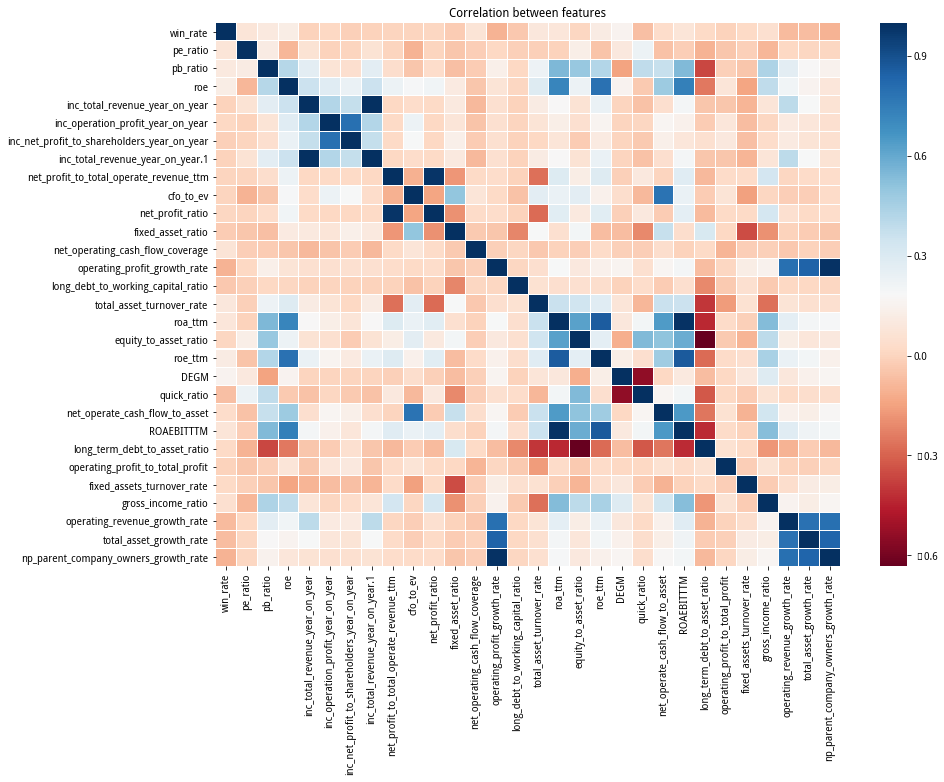

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax= plt.subplots(figsize = (14, 10))
sns.heatmap(corr_pd,cmap='RdBu', linewidths = 0.05, ax = ax)

# 设置Axes的标题
ax.set_title('Correlation between features')


In [19]:
corr_pd['win_rate']

win_rate                                       1.000000
pe_ratio                                       0.080542
pb_ratio                                       0.102064
roe                                            0.122393
inc_total_revenue_year_on_year                -0.006065
inc_operation_profit_year_on_year              0.013664
inc_net_profit_to_shareholders_year_on_year   -0.013643
inc_total_revenue_year_on_year.1              -0.006065
net_profit_to_total_operate_revenue_ttm        0.002500
cfo_to_ev                                      0.000834
net_profit_ratio                               0.008336
fixed_asset_ratio                             -0.022945
net_operating_cash_flow_coverage               0.073020
operating_profit_growth_rate                  -0.101127
long_debt_to_working_capital_ratio            -0.034367
total_asset_turnover_rate                      0.091605
roa_ttm                                        0.081983
equity_to_asset_ratio                          0